In [118]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
mpl.rcParams['figure.figsize']=12,8
from datetime import datetime

In [109]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

data = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv', parse_dates=[['year','month','day','hour']], index_col=0, date_parser=parse)
data = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')
data.drop(['year','month','day','hour'],axis=1,inplace=True)

data.drop('No',axis=1,inplace=True)

data.columns = ['pollution','dew','temp','press','wnd_dir','wnd_spd','snow','rain']

# data.index.name='date'

data['pollution'].fillna(0, inplace=True)
data = data[24:].reset_index()

In [77]:
data.to_csv('pollution.csv')

In [110]:
data.drop(['index'],axis=1,inplace=True)

In [111]:
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


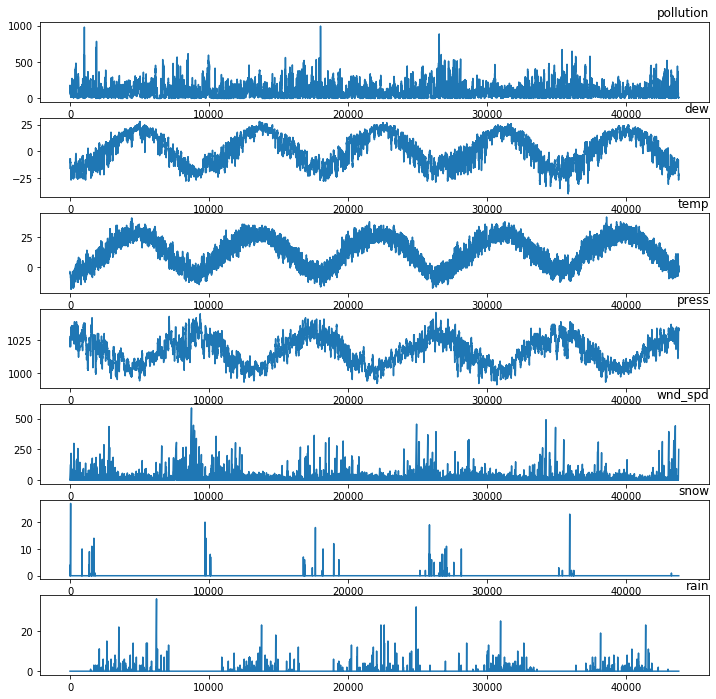

In [79]:
plt.figure(figsize=(12,12))
group=[0,1,2,3,5,6,7]
i=1
for item in group:
    plt.subplot(7,1,i)
    plt.plot(data.values[:,item])
    plt.title(data.columns[item],loc='right')
    i+=1
plt.show()

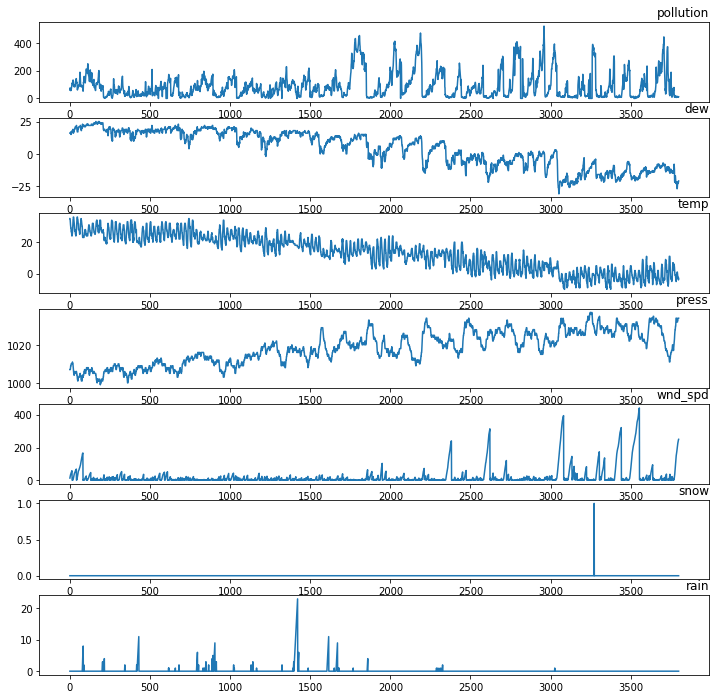

In [80]:
plt.figure(figsize=(12,12))
group=[0,1,2,3,5,6,7]
i=1
for item in group:
    plt.subplot(7,1,i)
    plt.plot(data.values[40000:,item])
    plt.title(data.columns[item],loc='right')
    i+=1
plt.show()

In [112]:
enc = OneHotEncoder(sparse=False)
obj_cols = ['wnd_dir']
trans = pd.DataFrame(enc.fit_transform(data[obj_cols]))
trans.columns=['dir_1','dir_2','dir_3','dir_4']
data.drop(obj_cols, axis=1, inplace=True)
oh_data = pd.concat([data, trans], axis=1)

In [117]:
def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
    '''
    	data: origin data
    	n_in: 
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(),list()
    
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)'%(j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names += [('var%d(t)'%(j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)'%(j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropna: # 是否去除缺失值的行
        agg.dropna(inplace=True)
    return agg

In [116]:
oh_data.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,dir_1,dir_2,dir_3,dir_4
0,129.0,-16,-4.0,1020.0,1.79,0,0,0.0,0.0,1.0,0.0
1,148.0,-15,-4.0,1020.0,2.68,0,0,0.0,0.0,1.0,0.0
2,159.0,-11,-5.0,1021.0,3.57,0,0,0.0,0.0,1.0,0.0
3,181.0,-7,-5.0,1022.0,5.36,1,0,0.0,0.0,1.0,0.0
4,138.0,-7,-5.0,1022.0,6.25,2,0,0.0,0.0,1.0,0.0


In [125]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(oh_data[[name for name in oh_data.columns]])

In [137]:
reframed_data = series_to_supervised(scaled_data, 1, 1)

In [183]:
useless_cols = reframed_data.columns[12:]
reframed_data.drop(useless_cols,axis=1,inplace=True)
reframed_data.head()
reframed_data.info()

train_ratio = 0.6
valid_ratio = 0.2

train_days = int(train_ratio*len(reframed_data))
valid_days = int(valid_ratio*len(reframed_data))
test_days = len(reframed_data)-train_days-valid_days

train = reframed_data.values[:train_days,:]
valid = reframed_data.values[train_days:train_days+valid_days,:]
test = reframed_data.values[train_days+valid_days:,:]

train_x, train_y = train[:,:-1], train[:,-1]
valid_x, valid_y = valid[:,:-1], valid[:,-1]
test_x, test_y = test[:,:-1], test[:,-1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

print(train_x.shape,train_y.shape,valid_x.shape,valid_y.shape,test_x.shape,test_y.shape)

def plot_history(model_history):
    plt.plot(model_history.history['loss'],label='train_loss')
    plt.plot(model_history.history['val_loss'],label='vlaid_loss')
    plt.legend()
    plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43799 entries, 1 to 43799
Data columns (total 12 columns):
var1(t-1)     43799 non-null float64
var2(t-1)     43799 non-null float64
var3(t-1)     43799 non-null float64
var4(t-1)     43799 non-null float64
var5(t-1)     43799 non-null float64
var6(t-1)     43799 non-null float64
var7(t-1)     43799 non-null float64
var8(t-1)     43799 non-null float64
var9(t-1)     43799 non-null float64
var10(t-1)    43799 non-null float64
var11(t-1)    43799 non-null float64
var1(t)       43799 non-null float64
dtypes: float64(12)
memory usage: 4.3 MB
(26279, 1, 11) (26279,) (8759, 1, 11) (8759,) (8761, 1, 11) (8761,)


In [184]:
model = keras.Sequential([
    keras.layers.LSTM(50, activation='relu', input_shape=(train_x.shape[1],train_x.shape[2])),
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
             loss='mean_squared_error')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                12400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________


In [185]:

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch%25==0:
            print(" ")
        print(".",end='')

model_history = model.fit(train_x, train_y,
                         epochs=50,
                         batch_size=72,
                         validation_data=(valid_x, valid_y),
                          verbose=0,
                        callbacks=[early_stop,PrintDot()],
                         shuffle=False)

 
......................... 
....

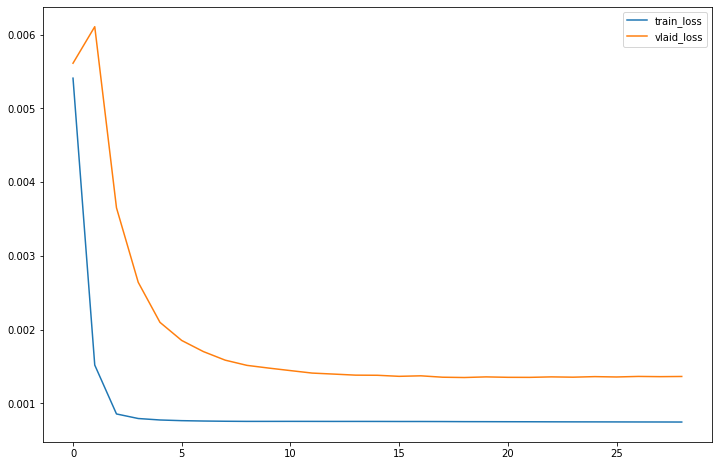

In [186]:
plot_history(model_history)

8761/8761 [==============================] - 1s 59us/step
0.0011636558504383146


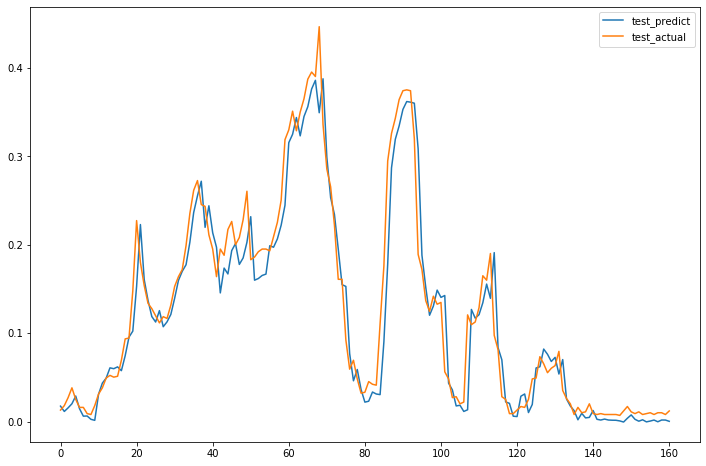

In [208]:
evaluate_res = model.evaluate(test_x,test_y)
print(evaluate_res)

preds = model.predict(test_x)
plt.plot(preds[8600:],label='test_predict')
plt.plot(test_y[8600:], label='test_actual')
plt.legend()
plt.show()

In [209]:

for i in range(10):
    preds=np.column_stack((preds, np.zeros(len(test_y))))
    
inverse_preds = scaler.inverse_transform(preds)
origin_test_y = oh_data['pollution'][train_days+valid_days:]
origin_test_y = [x for x in origin_test_y]

inverse_preds

array([[ 11.38690636, -40.        , -19.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 13.55207378, -40.        , -19.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 14.3338826 , -40.        , -19.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.81411403, -40.        , -19.        , ...,   0.        ,
          0.        ,   0.        ],
       [  1.77465182, -40.        , -19.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.35525993, -40.        , -19.        , ...,   0.        ,
          0.        ,   0.        ]])

In [197]:
origin_test_y

35038    20.0
35039    23.0
35040    24.0
35041    53.0
35042    65.0
         ... 
43795     8.0
43796    10.0
43797    10.0
43798     8.0
43799    12.0
Name: pollution, Length: 8762, dtype: float64

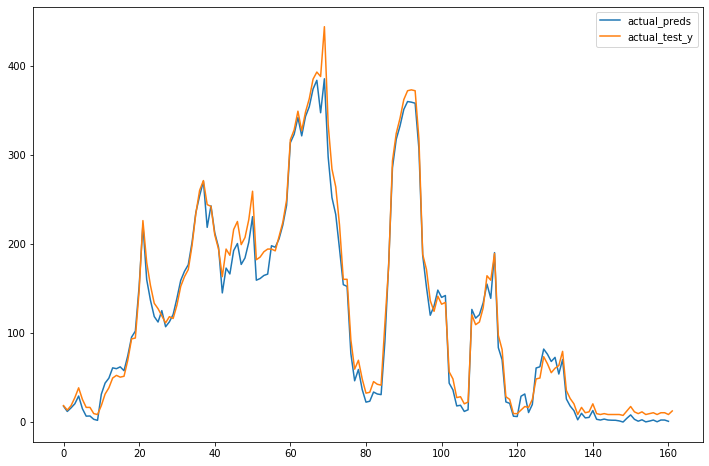

In [217]:
plt.plot(inverse_preds[8600:,0],label='actual_preds')
plt.plot(origin_test_y[8600:], label='actual_test_y')
plt.legend()
plt.show()